In [22]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import statsmodels.api as sm # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import statsmodels.formula.api as smf # type: ignore


### Data set "Animals"

[Animals dataset](https://stat.ethz.ch/R-manual/R-patched/library/MASS/html/Animals.html)

Average brain and body weights for 28 species of land animals.

In [23]:
url = 'https://drive.google.com/file/d/1wfUUKU2VbmK-WzehMKft8u1WMEfyOXTy/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?id=' + file_id

In [24]:
data = pd.read_csv(dwn_url, header=0, index_col=0)

- We want to use a linear model to study the relation between the brain weight and the body weight

- Simple linear regression (one predictor):

$brain=\beta_0+\beta_1*body+\varepsilon$


### Regression assumption on Y

- Our model: $Y=\beta_0+\beta_1*x+\varepsilon$

- Given that we assume the errors $\varepsilon$ to have normal distribution $\mathcal{N}(0,\sigma^2)$, we assume that also $Y$ are normally distributed.

- Check the assumption on $Y$

- If the response variable is not gaussian, a linear model should not be used.



### Transformations

Apply the necessary transformations to Y and X, use log transformation.

In [25]:
#Apply the necessary transformations to the data
data['log_brain'] = np.log(data['brain'])
data['log_body'] = np.log(data['body'])


### Outliers

Detect the outliers using boxplots, histograms or scatter plots. Findout which are the animals corresponding to the outliers.

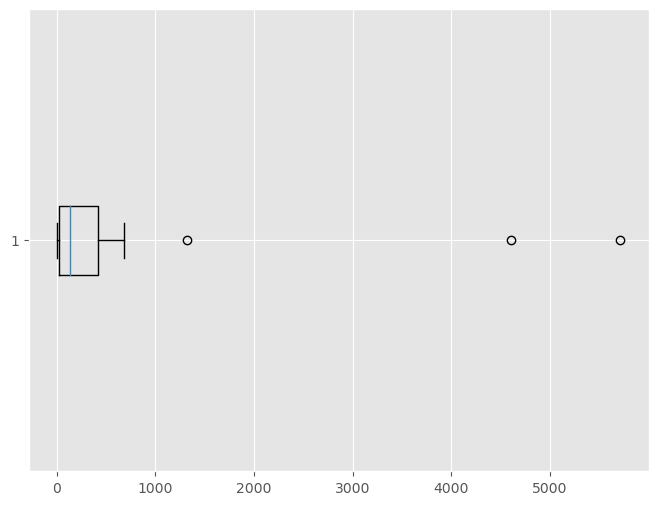

In [26]:
#Detect the outliers using boxplot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data[['brain']], vert=False)
plt.show()



In [27]:
def detect_outliers(df):
    outliers = {}
    for column in df.columns:
        # Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Definir los límites para los outliers
        lower_bound = Q1 - 15.5 * IQR
        upper_bound = Q3 + 15.5 * IQR
        # Identificar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        # Imprimir outliers para cada columna
        print(outliers[column])
    return outliers

# Obtener outliers
outliers = detect_outliers(data)

                  body  brain  log_brain   log_body
Dipliodocus    11700.0   50.0   3.912023   9.367344
Triceratops     9400.0   70.0   4.248495   9.148465
Brachiosaurus  87000.0  154.5   5.040194  11.373663
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []


### Annotations:
The outliers are 3: Dipliodocus, Triceratops, Brachiosaurus. They are all dinosaurs, and the only dinosaurs in the dataset

## Linear regression 1

Apply a simple linear regression using the model:

$\log(brain)=\beta_0+\beta_1*log(body)+\varepsilon $

In [28]:
xc = sm.add_constant(data['log_body'])
model1_simpleLinearRegression = sm.OLS(data['log_brain'], data['log_body'])

model1_results = model1_simpleLinearRegression.fit()
print(model1_results.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_brain   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.778
Method:                 Least Squares   F-statistic:                              99.10
Date:                Thu, 29 Aug 2024   Prob (F-statistic):                    1.56e-10
Time:                        14:08:39   Log-Likelihood:                         -63.293
No. Observations:                  28   AIC:                                      128.6
Df Residuals:                      27   BIC:                                      129.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
model1_results.params

log_body    0.84094
dtype: float64

Denoting with $Y_i$ the observations and with $\hat{Y_i}$ the estimations, the residuals are:

$residuals=|Y_i-\hat{Y_i}|$


Draw an histogram of the residuals and a scatter plot of residuals vs fittedvalues. Do the plots suggest a proper residual behavior?

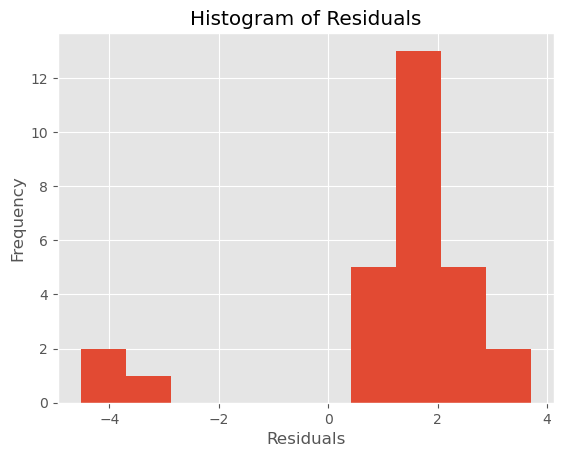

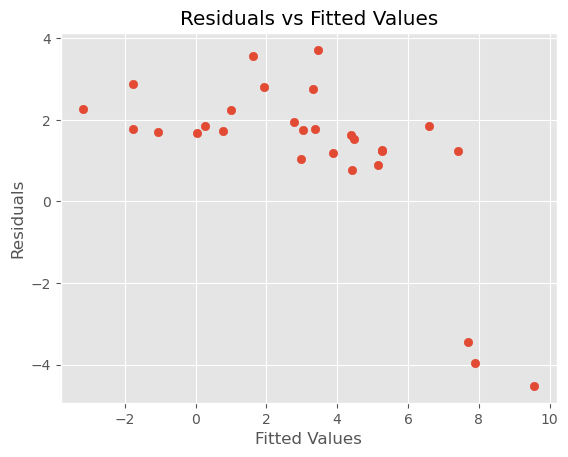

In [30]:
#Draw an histogram of the residuals and a scatter plot of residuals vs fittedvalues. Do the plots suggest a proper residual behavior?
# Draw an histogram of the residuals
plt.hist(model1_results.resid, bins=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Scatter plot of residuals vs fitted values
plt.scatter(model1_results.fittedvalues, model1_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Draw the regression line on the X,Y scatter plot.

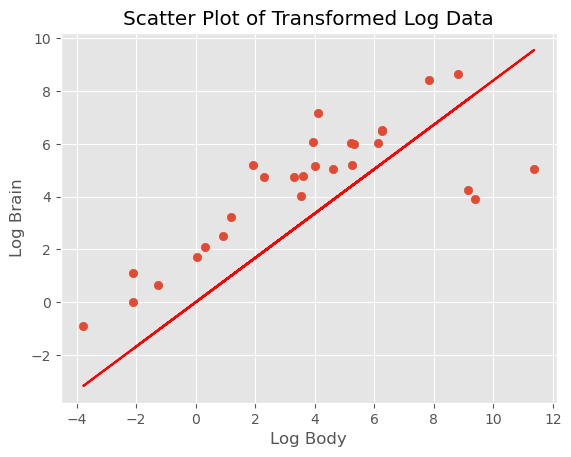

In [31]:
fig, ax = plt.subplots()
yy = data['log_body'] * model1_results.params[0]

# Scatter plot
ax.scatter(data['log_body'], data['log_brain'])

# Set labels and title
ax.set_xlabel('Log Body')
ax.set_ylabel('Log Brain')
ax.set_title('Scatter Plot of Transformed Log Data')

# Plot the line
ax.plot(data['log_body'], yy, color='red')

# Show the plot
plt.show()


### Dummy variables

Should I treat dinosaurs independently? One can make the dataset more interesting introducing dummy variables, one for each type of dinosaurs.

Create four dummy variables: one for Triceratops, one for Dipliodocus, one for Brachiosaurus and one for dinosaur in general.


In [32]:
# Introduce dummy variables for each dinosaur outlier
data['DummyT'] = (data.index == 'Triceratops').astype(int)
data['DummyD'] = (data.index == 'Dipliodocus').astype(int)
data['DummyB'] = (data.index == 'Brachiosaurus').astype(int)

# Define dummy variable for dinosaurs (any of the three above)
data['Dinosaur'] = data[['DummyT', 'DummyD', 'DummyB']].max(axis=1)

### Regression model with dummy variables: Linear regression 2

- New model with extra predictors:

$log(brain)=\beta_0+\beta_1*log(body)+\beta_2*DummyT+\beta_3*DummyD+\beta_4*DummyB+\varepsilon$

- A different intercept if it is a dinosaur. Suppose the animal is a triceratop: the variable DummyT is equal to 1, DummyD=DummyB=0.

$\log(brain)=\beta_0+\beta_1*log(body)+\beta_2=$

$(\beta_0+\beta_2)+\beta_1*log(body)$

The intercept is $\beta_0$ when the animal is not a triceratop, while it's $\beta_0+\beta_2$ when the animal is a triceratop.

With this model we consider three different intercepts for the three dinosaurs.



In [33]:
# Create the regression model with log(body), DummyT, DummyD, and DummyB as predictors
X = data[['log_body', 'DummyT', 'DummyD', 'DummyB']]
X = sm.add_constant(X)  # Add the intercept term
y = data['log_brain']

# Fit the model
model2_threeDinosaurInterceptLinearRegression = sm.OLS(y, X)
model2_results = model2_threeDinosaurInterceptLinearRegression.fit()

# Print the summary of the regression model
print(model2_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     68.00
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           2.10e-12
Time:                        14:08:39   Log-Likelihood:                -28.004
No. Observations:                  28   AIC:                             66.01
Df Residuals:                      23   BIC:                             72.67
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1504      0.201     10.720      0.0

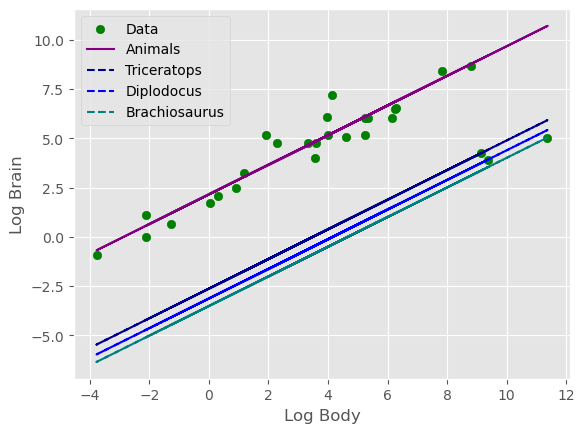

In [34]:
# Plot the scatter plot with log-transformed data
plt.scatter(data['log_body'], data['log_brain'], color='green', label='Data')

# Plot the regression line for non-dinosaurs
pred_non_dinosaurs = model2_results.params['const'] + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='purple', label='Animals')

# Plot the regression line for Triceratops
pred_triceratops = (model2_results.params['const'] + model2_results.params['DummyT']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_triceratops, color='darkblue', linestyle='--', label='Triceratops')

# Plot the regression line for Diplodocus
pred_diplodocus = (model2_results.params['const'] + model2_results.params['DummyD']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_diplodocus, color='blue', linestyle='--', label='Diplodocus')

# Plot the regression line for Brachiosaurus
pred_brachiosaurus = (model2_results.params['const'] + model2_results.params['DummyB']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_brachiosaurus, color='teal', linestyle='--', label='Brachiosaurus')

# Add labels and title
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.legend()
plt.show()


In [35]:
# Example prediction: Log body weight of 4, and it's a Triceratops
log_body_value = 3
is_triceratops = 0
is_diplodocus = 0
is_brachiosaurus = 1

# Create the predictor values
predicted_log_brain = (model2_results.params['const'] + 
                       model2_results.params['log_body'] * log_body_value + 
                       model2_results.params['DummyT'] * is_triceratops + 
                       model2_results.params['DummyD'] * is_diplodocus + 
                       model2_results.params['DummyB'] * is_brachiosaurus)

print(f'Predicted log brain weight: {predicted_log_brain}')


Predicted log brain weight: -1.25898389855917


### Annotations:


### Linear regression 3

- Model 2: same rate of change, but different intercept for dinasaurs

 $log(brain)=\beta_0+\beta_1*log(body)+\beta_2*Dino+\varepsilon$

 For an animal different from a dinosaur, the intercept is $\beta_0$. For a dinosaur the intercept is $\beta_0+\beta_2$.




In [36]:
# Create the regression model with log(body) and Dinosaur as predictors
X3 = data[['log_body', 'Dinosaur']]
X3 = sm.add_constant(X3)  # Add the intercept term
y = data['log_brain']

# Fit the model
model3_separateDinosaurInterceptLinearRegression = sm.OLS(y, X3)
model3_results = model3_separateDinosaurInterceptLinearRegression.fit()

# Print the summary of the regression model
print(model3_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     142.9
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           2.09e-14
Time:                        14:08:40   Log-Likelihood:                -28.446
No. Observations:                  28   AIC:                             62.89
Df Residuals:                      25   BIC:                             66.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1616      0.195     11.090      0.0

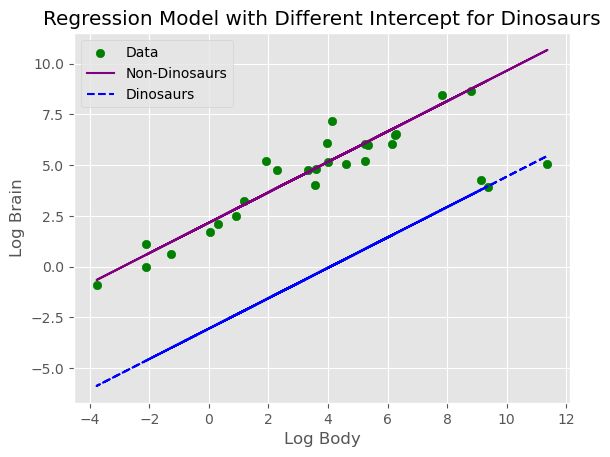

In [37]:
# Plot the scatter plot with log-transformed data
plt.scatter(data['log_body'], data['log_brain'], color='green', label='Data')

# Plot the regression line for non-dinosaurs
pred_non_dinosaurs = model3_results.params['const'] + model3_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='purple', label='Non-Dinosaurs')

# Plot the regression line for dinosaurs
pred_dinosaurs = (model3_results.params['const'] + model3_results.params['Dinosaur']) + model3_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_dinosaurs, color='blue', linestyle='--', label='Dinosaurs')

# Add labels and title
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.title('Regression Model with Different Intercept for Dinosaurs')
plt.legend()
plt.show()


In [38]:
# Example prediction: Log body weight of 4, and it's a dinosaur
log_body_value = 6
is_dinosaur = 1  # Set to 1 for dinosaurs, 0 for non-dinosaurs

# Create the predictor values
predicted_log_brain_dino = (model3_results.params['const'] + 
                            model3_results.params['log_body'] * log_body_value + 
                            model3_results.params['Dinosaur'] * is_dinosaur)

print(f'Predicted log brain weight for a dinosaur: {predicted_log_brain_dino}')


Predicted log brain weight for a dinosaur: 1.433605798304609


 ### Linear regression 4

 Different intercept and slope for dinosaurs. We add the feature where we multiply the variables "Dino" and "log(body)".

 $log(brain)=\beta_0+\beta_1*log(body)+\beta_2*Dino+\beta_3*log(body)*Dino+\varepsilon$

For an animal other than a dinosaur, the intercept is $\beta_0$ and the slope $\beta_1$. For a dinosaur, the intercept is $\beta_0+\beta_2$ and the slope is $\beta_1+\beta_3$.

In [39]:
# Create the interaction term: log_body * Dinosaur
data['log_body_Dinosaur'] = data['log_body'] * data['Dinosaur']

# Create the regression model with log(body), Dinosaur, and the interaction term as predictors
X_interaction = data[['log_body', 'Dinosaur', 'log_body_Dinosaur']]
X_interaction = sm.add_constant(X_interaction)  # Add the intercept term
y = data['log_brain']

# Fit the model
model4_dinosaurSlopeAndInterceptLinearRegression = sm.OLS(y, X_interaction)
model4_results = model4_dinosaurSlopeAndInterceptLinearRegression.fit()

# Print the summary of the regression model
print(model4_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     93.82
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           2.15e-13
Time:                        14:08:40   Log-Likelihood:                -28.113
No. Observations:                  28   AIC:                             64.23
Df Residuals:                      24   BIC:                             69.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1504      0.19

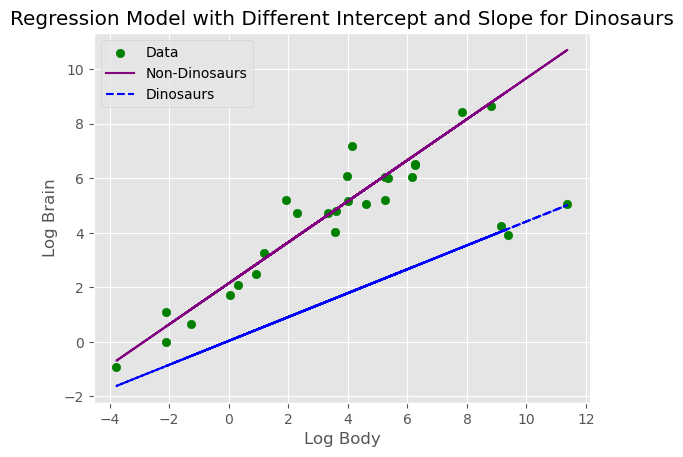

In [40]:
# Plot the scatter plot with log-transformed data
plt.scatter(data['log_body'], data['log_brain'], color='green', label='Data')

# Plot the regression line for non-dinosaurs
pred_non_dinosaurs = model4_results.params['const'] + model4_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='purple', label='Non-Dinosaurs')

# Plot the regression line for dinosaurs
pred_dinosaurs = (model4_results.params['const'] + model4_results.params['Dinosaur']) + \
                 (model4_results.params['log_body'] + model4_results.params['log_body_Dinosaur']) * data['log_body']
plt.plot(data['log_body'], pred_dinosaurs, color='blue', linestyle='--', label='Dinosaurs')

# Add labels and title
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.title('Regression Model with Different Intercept and Slope for Dinosaurs')
plt.legend()
plt.show()


In [41]:
# Example prediction: Log body weight of 4, and it's a dinosaur
log_body_value = 2
is_dinosaur = 1  # Set to 1 for dinosaurs, 0 for non-dinosaurs

# Create the predictor values
predicted_log_brain_interaction = (model4_results.params['const'] + 
                                   model4_results.params['log_body'] * log_body_value + 
                                   model4_results.params['Dinosaur'] * is_dinosaur + 
                                   model4_results.params['log_body_Dinosaur'] * log_body_value * is_dinosaur)

print(f'Predicted log brain weight with interaction: {predicted_log_brain_interaction}')


Predicted log brain weight with interaction: 0.9135404590633809


Which is the best model?

In [42]:
# Decide which model is the best
#Model 1: R-squared = 0.786, Adj. R-squared = 0.778
#Model 2: R-squared = 0.922, Adj. R-squared = 0.908
#Model 3: R-squared = 0.920, Adj. R-squared = 0.913
#Model 4: R-squared = 0.921, Adj. R-squared = 0.912